In [2]:
'''Example of VAE and AE on MNIST dataset using a CNN.
There are three models the encoder, decoder and autoencoder.
The encoder generates the latent variables and the 
decoder can be used to generate MNIST digits by sampling. The VAE
restricts the latent vector/variable to be from a Gaussian distribution 
with mean = 0 and std = 1. This example was adapted fro
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Load the module we need
# Note that we are import the Keras backend, which is assumed to be Tensorflow
import tensorflow as tf
import os
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.layers import UpSampling2D, Reshape
from keras.models import Model
from keras.optimizers import Adagrad
from keras import backend as K

from keras.datasets import mnist
import numpy as np

import matplotlib.pyplot as plt

from keras.layers import Lambda
from keras.losses import mean_squared_error, binary_crossentropy, KLDivergence
from keras.utils import plot_model



In [3]:
# This function samples random points from a distribution
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent subspace
    if (model_name == 'vae_mlp'):
        z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    else:
        z_mean = encoder.predict(x_test,batch_size=batch_size)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(np.amin(z_mean[:,0]), np.amax(z_mean[:,0]), n)
    grid_y = np.linspace(np.amin(z_mean[:,1]), np.amax(z_mean[:,1]), n)[::-1]

    z_sample = np.zeros((1,5))
    z_sample[0,2] = np.mean(z_mean[:,2])
    z_sample[0,3] = np.mean(z_mean[:,3])
    z_sample[0,4] = np.mean(z_mean[:,4])    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample[0,0] = xi
            z_sample[0,1] = yi
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [4]:
# Load MNIST datasets (training and test)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
# Define the Encoder, inputs are the MNIST 28x28 greyscale images 
input_img = Input(shape=(28, 28, 1))  

x = Conv2D(32, (3, 3), activation='relu',padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu')(x)
x = Reshape((128,))(x)
z = Dense(5,activation='linear')(x)    

encoded = Model(input_img,z,name='encoded')
encoded.summary()
plot_model(encoded, to_file='AE_encoded.png', show_shapes=True)            

# Latent space is a 5 dimensional vector space

# This is the decoder, it take the 5 dim latent vector and generates a 28x28 image
lats = Input(shape=(5,),name='latent')
x = Dense(128,activation='relu')(lats)
x = Reshape((4,4,8))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
rec = Conv2DTranspose(1, (3, 3), activation='relu',padding="same")(x)

decoded = Model(lats,rec,name='decoded')
decoded.summary()
plot_model(decoded, to_file='AE_decoded.png', show_shapes=True)     

# The autoencoder takes the image as input encodes it, then decodes it
rec = decoded(encoded(input_img))
autoencoder = Model(input_img,rec)

reconstruction_loss = tf.reduce_mean(1000.0*tf.square(input_img-rec),axis=(1,2))
autoencoder.add_loss(reconstruction_loss)
autoencoder.compile(optimizer='adadelta')
autoencoder.summary()

Model: "encoded"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,749 (26.36 KB)

 Trainable params: 6,749 (26.36 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "decoded"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ latent (InputLayer)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 6, 6, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,865 (26.82 KB)

 Trainable params: 6,865 (26.82 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [6]:
# Train the model, this can take some time
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))
autoencoder.save_weights('ae_mlp_mnist.h5')

Epoch 1/100
469/469 [==============================] - 49s 103ms/step - loss: 108.9773 - val_loss: 107.8297
Epoch 2/100
469/469 [==============================] - 50s 108ms/step - loss: 90.1040 - val_loss: 71.8376
Epoch 3/100
469/469 [==============================] - 46s 97ms/step - loss: 68.8943 - val_loss: 67.7758
Epoch 4/100
469/469 [==============================] - 45s 97ms/step - loss: 66.6646 - val_loss: 66.2900
Epoch 5/100
469/469 [==============================] - 46s 98ms/step - loss: 65.6210 - val_loss: 65.4347
Epoch 6/100
469/469 [==============================] - 46s 98ms/step - loss: 64.9384 - val_loss: 64.8010
Epoch 7/100
469/469 [==============================] - 46s 98ms/step - loss: 64.3967 - val_loss: 64.2677
Epoch 8/100
469/469 [==============================] - 46s 97ms/step - loss: 63.9234 - val_loss: 63.7924
Epoch 9/100
469/469 [==============================] - 45s 97ms/step - loss: 63.4925 - val_loss: 63.3527
Epoch 10/100
469/469 [=============================

469/469 [==============================] - 44s 94ms/step - loss: 48.6670 - val_loss: 48.3361
Epoch 79/100
469/469 [==============================] - 45s 96ms/step - loss: 48.5631 - val_loss: 48.2323
Epoch 80/100
469/469 [==============================] - 46s 98ms/step - loss: 48.4608 - val_loss: 48.1307
Epoch 81/100
469/469 [==============================] - 46s 98ms/step - loss: 48.3603 - val_loss: 48.0310
Epoch 82/100
469/469 [==============================] - 45s 96ms/step - loss: 48.2617 - val_loss: 47.9333
Epoch 83/100
469/469 [==============================] - 47s 100ms/step - loss: 48.1653 - val_loss: 47.8374
Epoch 84/100
469/469 [==============================] - 47s 101ms/step - loss: 48.0707 - val_loss: 47.7451
Epoch 85/100
469/469 [==============================] - 46s 97ms/step - loss: 47.9779 - val_loss: 47.6531
Epoch 86/100
469/469 [==============================] - 47s 100ms/step - loss: 47.8863 - val_loss: 47.5618
Epoch 87/100
469/469 [==============================] - 

313/313 [==============================] - 3s 9ms/step


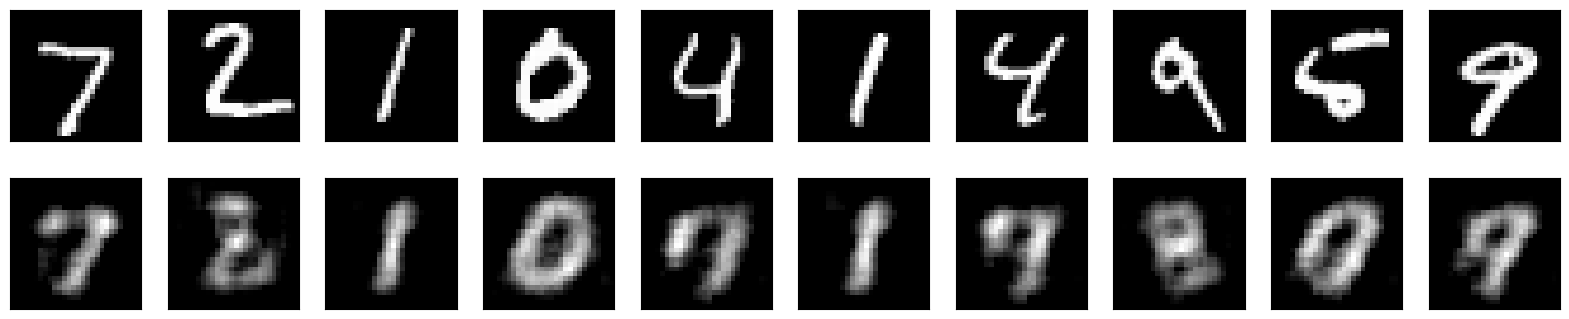

In [7]:
# Show a sample of test images that have been through the autoencoder
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

79/79 [==============================] - 1s 9ms/step


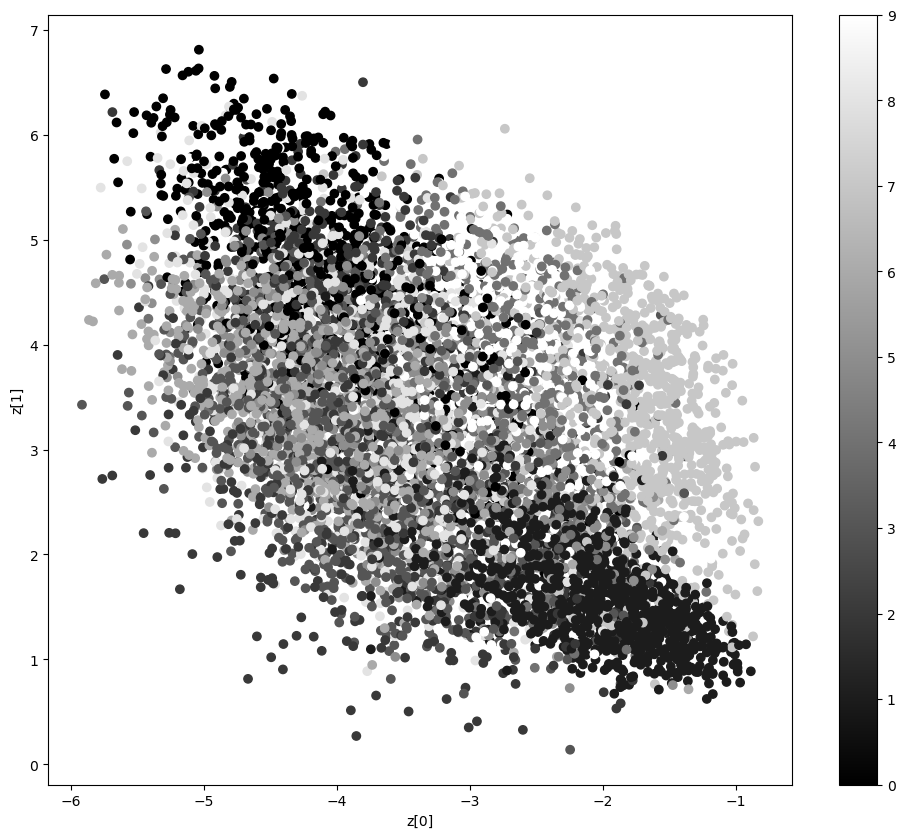

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


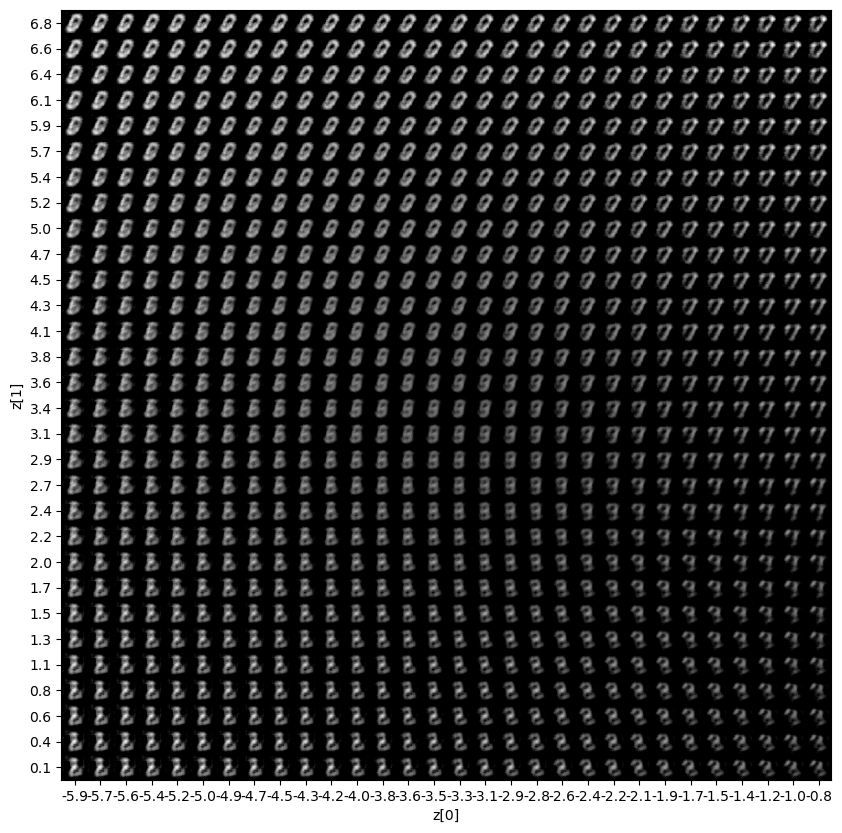

In [8]:
# Use the plot_results function to show a latent subspace 
# Use a grid of latent variables to generate MNIST images
batch_size=128
plot_results((encoded,decoded),
            (x_test,y_test),
                 batch_size=batch_size,
                 model_name="AE")

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 12, 12, 16)   4624        ['max_pooling2d_2[0][0]']        
                                                                                            

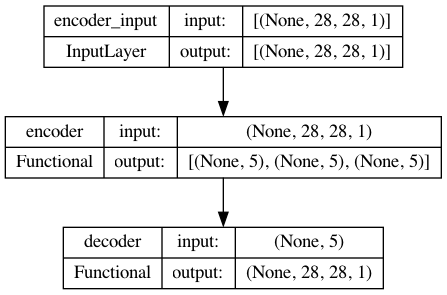

In [9]:
input_shape = (28,28,1)
batch_size = 128
latent_dim = 5
epochs = 20


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, (3, 3), activation='relu',padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu')(x)
x = Reshape((128,))(x)
z_mean = Dense(latent_dim,activation='linear',name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var',activation='linear')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)



# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(128,activation='relu')(latent_inputs)
x = Reshape((4,4,8))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2DTranspose(1, (3, 3), activation='relu',padding='same')(x)


# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()
plot_model(vae,to_file='vae_mlp.png',show_shapes=True)


In [10]:
# Generate the new loss function with the reconstruction error and the Kulback-Leibler
# divergence

reconstruction_loss = tf.reduce_mean(1000.0*tf.square(inputs-outputs),axis=(1,2))
z = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(-0.5*z, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.add_metric(tf.reduce_sum(1000.0*tf.square(inputs-outputs),axis=(1,2)),name='rec_loss',aggregation='mean')
vae.add_metric(tf.reduce_sum(-0.5*z, axis=-1),name='kl_loss',aggregation='mean')
vae.compile(optimizer='adam')

# Train the model
vae.fit(x_train,epochs=epochs,batch_size=128)
vae.save_weights('vae_mlp_mnist.h5')



Epoch 1/20
469/469 [==============================] - 51s 107ms/step - loss: 58.4628 - rec_loss: 42225.9688 - kl_loss: 4.6098
Epoch 2/20
469/469 [==============================] - 53s 112ms/step - loss: 45.9437 - rec_loss: 30279.3984 - kl_loss: 7.3212
Epoch 3/20
469/469 [==============================] - 54s 116ms/step - loss: 44.2413 - rec_loss: 28666.4375 - kl_loss: 7.6768
Epoch 4/20
469/469 [==============================] - 53s 112ms/step - loss: 43.3679 - rec_loss: 27857.7754 - kl_loss: 7.8364
Epoch 5/20
469/469 [==============================] - 54s 115ms/step - loss: 42.7721 - rec_loss: 27304.8496 - kl_loss: 7.9445
Epoch 6/20
469/469 [==============================] - 54s 114ms/step - loss: 42.3449 - rec_loss: 26903.5156 - kl_loss: 8.0312
Epoch 7/20
469/469 [==============================] - 50s 107ms/step - loss: 42.0031 - rec_loss: 26567.5410 - kl_loss: 8.1155
Epoch 8/20
469/469 [==============================] - 52s 112ms/step - loss: 41.7295 - rec_loss: 26311.8242 - kl_loss:

313/313 [==============================] - 4s 13ms/step


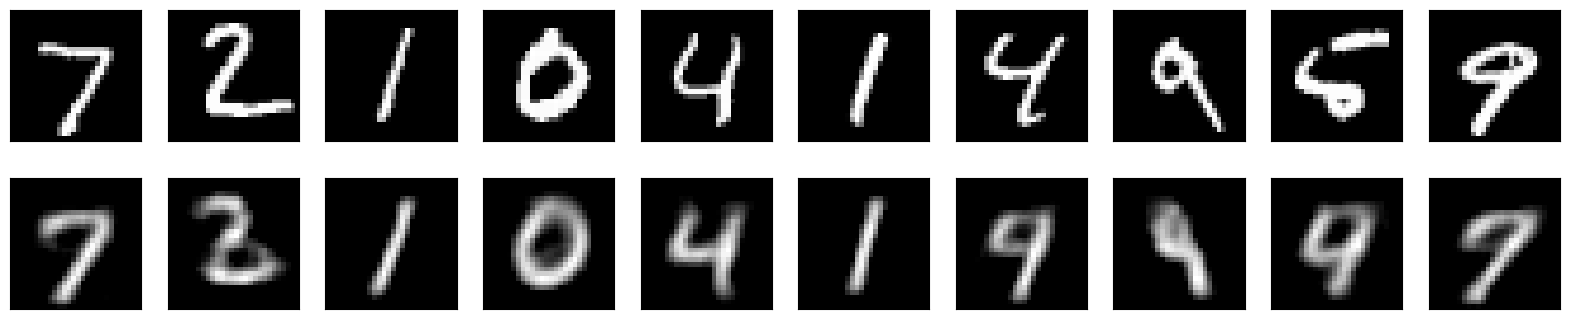

In [11]:
# Show some reconstruction examples from the test set

decoded_imgs = vae.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

79/79 [==============================] - 1s 8ms/step


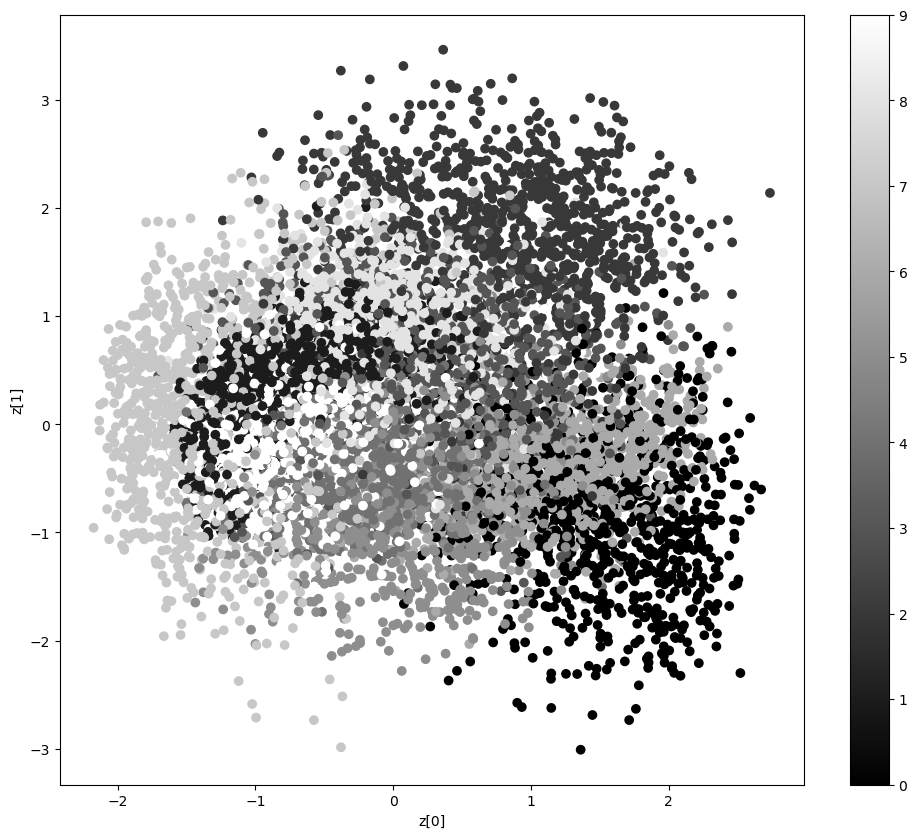

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


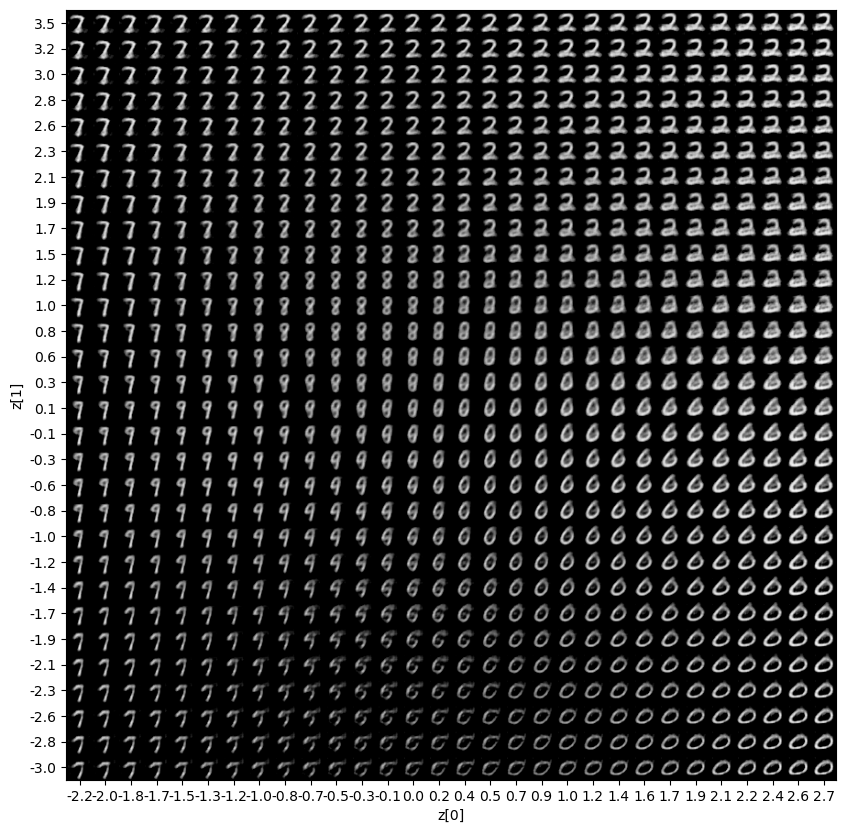

In [12]:
# Plot the latent subspace and generate MNIST images from a grid in latent space
plot_results((encoder,decoder),
            (x_test,y_test),
                 batch_size=batch_size,
                 model_name="vae_mlp")